# Deutsch-Jozsa Algorithm

## Table of contents
- [Imports and requirements](#imports-and-requirements)
- [Runtime setup](#ibm-quantum-runtime-setup)
- [Step 1: Map](#step-1-map)
- [Step 2: Optimize](#step-2-optimize)
- [Step 3: Execute](#step-3-execute)
- [References](#referances)



## Imports and requirements


To run this notebook it is requiered a python version >= 3.10, personally, I am using python 3.11

In [1]:
from platform import python_version
print(python_version())

3.11.13


# Requieremts
%pip install os
%pip install qiskit
%pip install qiskit_ibm_runtime
%pip install numpy
%pip install matplot
%pip ipywidgets
%pip install python-dotenv

In [2]:
from dotenv import load_dotenv
import os
import random
import qiskit
from qiskit import QuantumCircuit,QuantumRegister, ClassicalRegister, generate_preset_pass_manager
from qiskit import transpile
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp


from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.primitives import  SamplerV2 as Sampler
from qiskit_aer import AerSimulator

In [3]:
print(f"Qiskit version: {qiskit.__version__}")

Qiskit version: 2.1.1


You should have Qiskit version `>=2.0.0`. If you see a lower version, you need to restart your kernel and reinstall the library.

## IBM Quantum Runtime setup
Firstly we will setup the qiskit_ibm_runtime service so we can execute our circuit on a real hardware.
> ⚠️ **Note:**  
> It is highly recommended to check the [official IBM Quantum documentation](https://quantum.ibm.com/docs/).  
>
> In this notebook, we will use the **`.env` method**.  
> Create a `.env` file in the same folder as this notebook and write your **API key** and **CRN** there.  
>
> This approach keeps your credentials secure and out of the public repository.


In [4]:
# Load automatically the .env file from the root of the project 
load_dotenv(override=True)

# Check if the environment variables are set
print("🔑 Token (first 6 chars):", os.environ["IBM_QUANTUM_TOKEN"][:6], "...")

# Setup the IBM Quantum Runtime service
service = QiskitRuntimeService(
    channel=os.environ["IBM_QUANTUM_CHANNEL"],
    token=os.environ["IBM_QUANTUM_TOKEN"],
    instance=os.environ["IBM_QUANTUM_INSTANCE"]
)
# Check the available backends, if error then your .env is not correctly set
print("Available backends:")
backends = service.backends()
for backend in service.backends():

    print(" -", backend.name)

🔑 Token (first 6 chars): b3fr8e ...
Available backends:
 - ibm_brisbane
 - ibm_torino


---

##  Environment Setup Summary

At this point, we have:
- Created a secure **`.env`** file containing our API key and CRN.  
- Configured the connection using **`QiskitRuntimeService`** without saving any credentials locally.  
- Verified that the environment variables are correctly loaded.

Now we are ready to start implementing the **Deutsch–Jozsa algorithm** using Qiskit.  
In the following sections, we will:
1. Review the theoretical foundations of the algorithm.  
2. Build the corresponding quantum circuits step by step.  
3. Test both **constant** and **balanced** functions on simulators and, optionally, on a real quantum backend.

---


# Deutsch-Jozsa-algorithm-implementation

## Introduction
The Deutsch–Jozsa algorithm distinguishes between constant and balanced functions exponentially faster than any classical deterministic algorithm. Even if it is not a usefull algorithm in a practical way, it is a simple example to show the quantum advantage.


## Algorithm description
Deutsch algorithm solves the parity problem for functions such as:

$$
\sum \;\; \longrightarrow \sum
$$
<br>
Deutsch-Jozsa algorithm is the extension of the Deustch algorithm for functions such as:

$$\sum^n \;\;\longrightarrow\;\; \sum \; , \quad n \geq 1 $$

To describe how this algorithm works , imagine this game: Alice, in LA sends a bit string to Bob, who is in NY. Bob calculates the image of some function $ f(x) $ that could work in two different ways. First  $f(x) = 0 \ $  or  $ f(x) = 1 $ , but never both, constant. Otherwise $ f(x) = 0 $ half of the times , $ f(x) = 1 $ the other half, balanced. The goal of Alice is knowing how this $ f(x) $ work, constant or balanced. 

If Bob agrees to use an unitary operator $ U_f $ then, Alice only needs a single query to know how the function $ f(x) $ behaves. On the other hand, the best classical method would require $ 2^{n-1} +1 $  queries.

We will follow the Qiskit workflow pattern: **Map → Optimize → Execute → Post-process**.  
This is the standard workflow used for implementing all quantum algorithms.

## Step 1: Map

Firstly we will setup our qubits. This means $|0\rangle^{\otimes n}$ for Alice and $ |1\rangle $ for Bob's qubit.



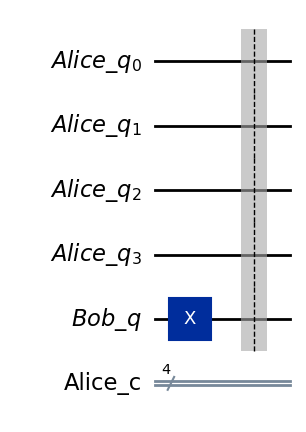

In [5]:
# Define the initial state |ψ0⟩ = |0...01⟩
def psi_0(n:int):
    alice_qr = QuantumRegister(n,name='Alice_q')
    bob_qr = QuantumRegister(1,name= 'Bob_q')
    alice_cr = ClassicalRegister(n,name='Alice_c')
    qc = QuantumCircuit(alice_qr,bob_qr,alice_cr)
    qc.x(n)
    qc.barrier()
    return qc,alice_qr,alice_cr,bob_qr
# For example n = 4, 4 qubits for Alice and 1 for Bob
n = 4
qc,alice_qr,alice_cr,bob_qr = psi_0(n)
qc.draw('mpl')

As you can see. We initialize the circuit in the state $$ |\psi_0\rangle = |0\rangle^{\otimes n} |1\rangle $$ <br> 
To continue we need to create an entangled $|\psi_1\rangle =  H^{\otimes n+1}|\psi_0\rangle $ 
which is $$  H^{\otimes n}|0\rangle  \otimes H|1\rangle$$

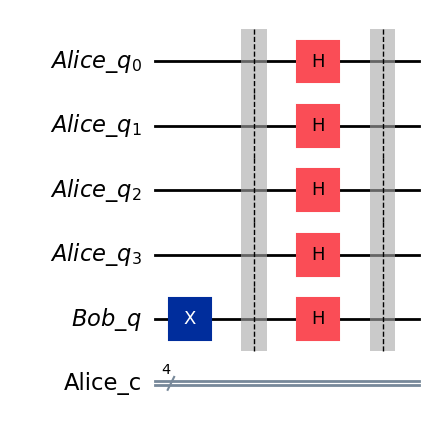

In [6]:
def psi_1(qc:QuantumCircuit,n:int,alice_qr:QuantumRegister,alice_cr:ClassicalRegister,bob_qr:QuantumRegister)->QuantumCircuit:
    qc.h(alice_qr)
    qc.h(bob_qr)
    qc.barrier()
    return qc
qc= psi_1(qc,n,alice_qr,alice_cr,bob_qr)
qc.draw('mpl')

We obtain$$ |\psi_1 \rangle = \displaystyle\sum_{x \in \{0,1\}^n}  \frac{|x\rangle}{\sqrt{2^n}} \otimes \frac{|0\rangle - |1\rangle}{\sqrt{2}} $$ <br>
For example for $ n = 2 $ $$  |\psi_1\rangle = \frac {|00\rangle +|01\rangle + |10\rangle + |11\rangle}{2} \otimes \frac{|0\rangle - |1\rangle}{\sqrt{2}}  $$ <br>


Now the query register is a superposition of all values. Then it is Bob's turn to evaluate $$ U_f : |Alice,Bob\rangle \rightarrow |Alice,Bob \oplus f(x)\rangle$$ <br>

It is important to understand how $ f(x) $ is chosen. Initially before we execute the quantum circuit an oracle chooses between balanced or constant function. For all shots of the execution this decision will be maintained. Now let's recap how $f(x) $ works:
$$
constant \rightarrow f(x) = 
\begin{cases}
0 \ \forall x
\\
1 \ \forall x 

\end{cases}

$$

$$
balanced \ \longrightarrow\
|\{x : f(x)=0\}| = |\{x : f(x)=1\}| = 2^{n-1}
$$

In [7]:
# Define a seed for better reproduction
seed = 23
# Which function we will use for one execution
def choose_const_bal(n=random.random(),n2=random.random())->int:
    if n <= 0.5:
        if n2 <= 0.5: 
            return 0 # if output 0 -> const0
        else:
            return 1 # if output 1 -> const1
    else:
        return 10 # if output 10 -> balanced
        
which_fun = choose_const_bal()
print(which_fun)

10


As we have seen, $f(x)$ can output 2 values rather if it is balanced or constant. Let's check how $ U_f $ works:
$$
|\psi_2\rangle = \frac{1}{\sqrt{2^n}} \big[ U_f|x,0\rangle - U_f|x,1\rangle] = \frac{1}{\sqrt{2^n}} \big[ |x,0\oplus f(x)\rangle - |x,1\oplus f(x)\rangle] = \frac{1}{\sqrt{2^n}} \big[ |x,f(x)\rangle - |x,1\oplus f(x)\rangle]
$$ 
<br>




Now we will explain how $ U_f $ will change depending on the posible values of  $ f(x) $
$$
f(x) = 0 \longrightarrow |\psi_2\rangle = \frac {1}{\sqrt{2^n}} |x,0\rangle - |x,1\rangle \\
f(x) = 1 \longrightarrow |\psi_2\rangle = \frac {1}{\sqrt{2^n}} |x,1\rangle - |x,0\rangle  =\frac {1}{\sqrt{2^n}} \big[ -|x,0\rangle-|x,1\rangle\big]

$$
$$ |\psi_2\rangle = \sum_x \frac{(-1)^{f(x)}|x\rangle}{\sqrt{2^n}} \big[ \frac {|0\rangle-|1\rangle }{\sqrt{2}}\big] $$

This phenomena is called phase kickback. This quantum property is one of the most useful  within quantums algorithms. For more detail see: https://quantum.cloud.ibm.com/learning/en/courses/fundamentals-of-quantum-algorithms/phase-estimation-and-factoring/phase-estimation-procedure

Let's express this phenomena in terms of quantum gates.

In [8]:
#Let's define all the posible functions
def constan0(qc:QuantumCircuit)->QuantumCircuit:
    # We apply the identity
    return qc

def constant1(qc:QuantumCircuit,alice_qr:QuantumRegister)->QuantumCircuit:
    qc.x(alice_qr)
    return qc

For the balanced function, we should be more cautious. As we can seen $ U_f $ is applied to each $ |x\rangle $. So in the case
$$ 
f(x) = x \longrightarrow  |x\rangle |y\oplus x\rangle \longrightarrow CNOT
$$ 
In the second case:
$$
f(x) =  \neg x \longrightarrow  |x\rangle |y\oplus  \neg x\rangle   ~=~ |x\rangle |y\oplus ( 1 \oplus x\rangle ) =  |x\rangle |(y\oplus  1 )\oplus  x\rangle  \longrightarrow  X \ CNOT
$$

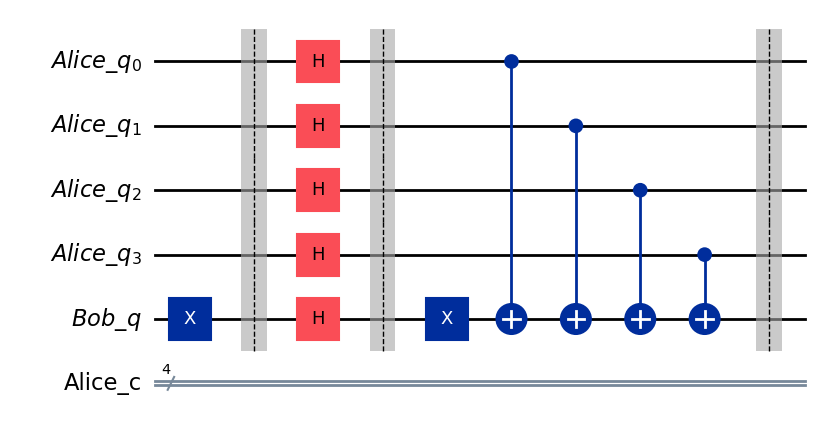

In [9]:
def balanced(qc:QuantumCircuit,n:int,alice_qr:QuantumRegister,bob_qr:QuantumRegister,balancer)->QuantumCircuit:
    if balancer <=0:
        balancer = random.random()
        print('Balancer was less than 0, new value assigned:', balancer)
    elif balancer >=1:
        balancer = random.random()
        print('Balancer was greater than 1, new value assigned:', balancer)
    if balancer <= 0.5: 
        qc.cx(alice_qr,bob_qr) # N CNOT gates 
        return qc
    else:
        qc.x(bob_qr)
        qc.cx(alice_qr,bob_qr) 
        return qc

def uf(qc:QuantumCircuit,n:int,which_fun:int,alice_qr:QuantumRegister,balancer = random.random())->QuantumCircuit:
    if which_fun == 0:
        qc = constan0(qc)
    elif which_fun == 1:
        qc= constant1(qc,alice_qr)
    else:
        qc = balanced(qc,n,alice_qr,bob_qr,balancer)
    qc.barrier()
    return qc

qc = uf(qc,n,which_fun,alice_qr)
qc.draw('mpl')

To conclude, we just have to apply a Hadamard gate to Alice's qubits, and measure them.

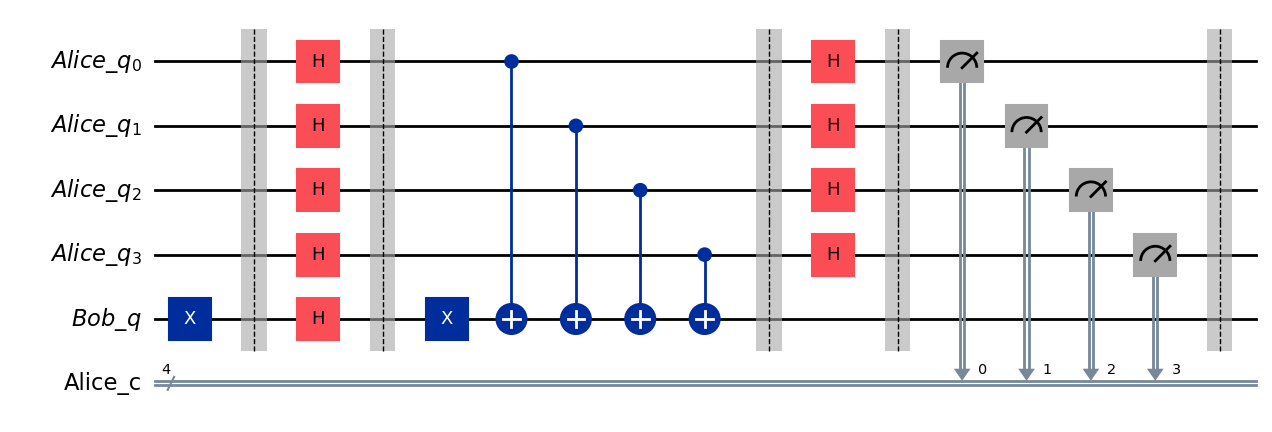

In [10]:
def psi_3(qc:QuantumCircuit,n:int,alice_qr:QuantumRegister,alice_cr:ClassicalRegister,bob_qr:QuantumRegister)-> QuantumCircuit:
    qc.h(alice_qr)
    qc.barrier()
    qc.measure(alice_qr,alice_cr)
    qc.barrier()
    return qc
qc = psi_3(qc,n,alice_qr,alice_cr,bob_qr)
qc.draw('mpl')

Finally we obtein:
$$
|\psi_3\rangle = H ^{\otimes n}|x\rangle |y\rangle \longrightarrow
|\psi_3\rangle = \sum_z \sum_x \frac{(-1)^{xz+f(x)}|z\rangle}{2^n} \big[ \frac{|0\rangle-|1\rangle}{\sqrt{2}}\big]
$$
Where $ zx $ is the bitwise inner produnct modulo 2. <br>
At last, is Alice's turn to measure her query registers. The amplitudes should be
$$
f(x) = constant \rightarrow \pm1 \\
f(x) = balanced \rightarrow 0
$$
And we should measure
$$
f(x) = constant \rightarrow 0  \ \forall qubits \\
f(x) = balanced \rightarrow \ne 0 \ for \ at \ least \ 1 \ qubit
$$
Now our Quantum Circuit is finally complete. Let's group all of our functions.

In [11]:
def Deutsch_Jozsa_circuit(n:int,which_fun = choose_const_bal,balancer = random.random())-> QuantumCircuit:
    qc,alice_qr,alice_cr,bob_qr = psi_0(n)
    qc= psi_1(qc,n,alice_qr,alice_cr,bob_qr)
    # It's important to clarify that if we do not give any value to 'which_fun' then it will be random
    if which_fun not in [0,1,10]:
        print('Incorrect value for which_fun, a random function will be chosen')
        which_fun = choose_const_bal()
    qc = uf(qc,n,which_fun,alice_qr,balancer)
    qc = psi_3(qc,n,alice_qr,alice_cr,bob_qr)
    return qc


Incorrect value for which_fun, a random function will be chosen


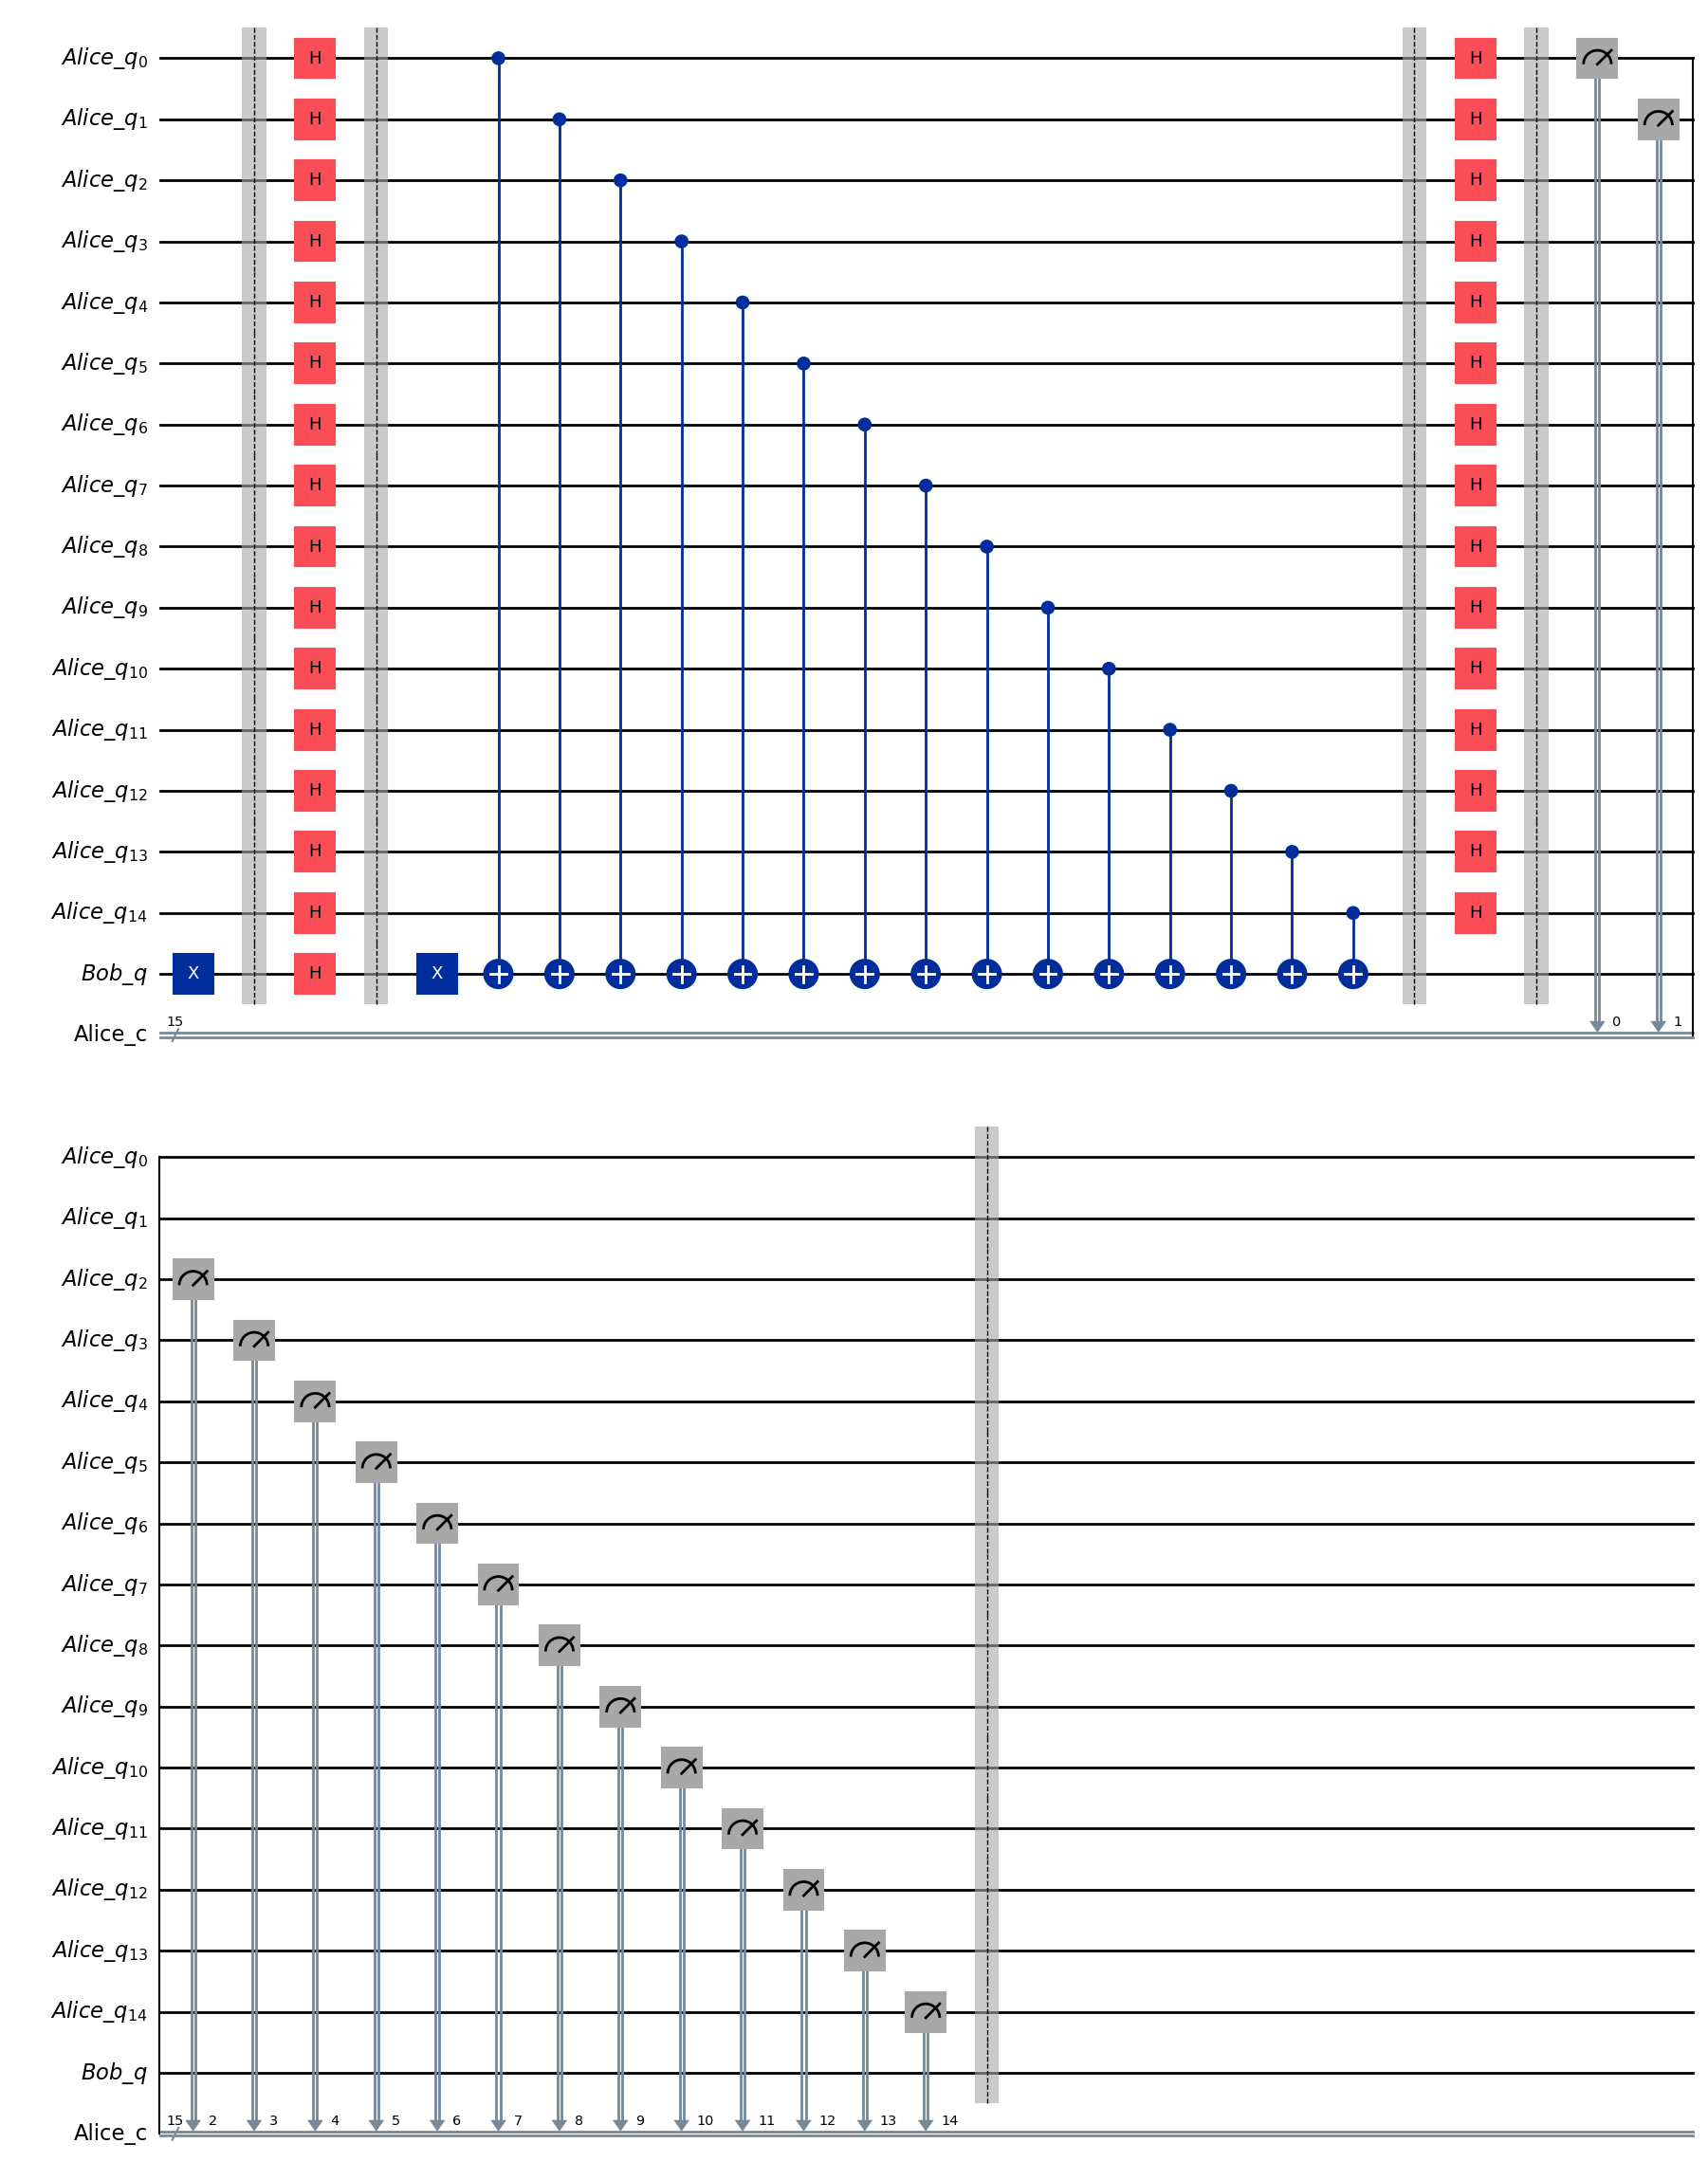

In [18]:
qc1 = Deutsch_Jozsa_circuit(n = 6, which_fun=10,balancer=0.7)
draw1 = qc1.draw('mpl')
qc2 = Deutsch_Jozsa_circuit(n = 6, which_fun=10,balancer=0.3)
draw2 = qc2.draw('mpl')
qc3 = Deutsch_Jozsa_circuit(n = 15)
draw3 = qc3.draw('mpl')
# To visualize the circuits eliminate the # before the coments below
#qc1.draw('mpl')
#draw2
draw3

## Step 2: Optimize 
Following the qiskit workflow. It is turn to optimize our circuit, for decreasing the different types of errors such as: two qubit gates error, really important in the case of $ f(x) = \neg x$, the T2 error or Desphasing error, or the readout error because we apply n measurements.


In [ ]:
# Transpile the circuit for the selected backend
# We will chose the least busy available backend
real_backend = service.least_busy(operational=True, simulator=False)
pm = generate_preset_pass_manager(backend=real_backend, optimization_level=1,layout_method='sabre')
isa_qc = transpile(qc,backend=real_backend)
# isa_qc.draw('mpl')

As our circuit does not have much size we will use optimeze level = 1. If you are tranpiling a quantum circuit with $ n \geq 100 $ qubits consider using level 2. 

## Step 3: Execute
Now that we have our qc optimized for the selected backend, we can execute it. It is important to understand that unless our quantum circuit has at least 100 qubits, classical computer be better than any quantum hardware. 
<br>
To start, we will run our quantum circuit with the Qiskit primitives on the Aer simulator before moving to real hardware. 

In [ ]:
shots = 1000

backend_aer = AerSimulator()
sampler = Sampler()
aer_qc = transpile(qc1, backend=backend_aer)

# Execute the circuit on the Aer simulator
result_aer = sampler.run([aer_qc], shots=shots).result()

# Access the counts from the classical register (default "meas" or the name of your register)
counts_aer = result_aer[0].data.Alice_c.get_counts()
print("Counts:", counts_aer)

Counts: {'111111': 1000}


Let's execute our quantum circuit on real quantum computer.
> ⚠️ **Note :** 
> Running on a **real quantum device** will consume your free QPU time (10 minutes per month in the Open Plan).  
> Consider testing your circuit on the previous python cell.


In [ ]:
# 

## Referances 
Nielsen & Chuang, sections 1.4.2–1.4.4.
ttps://quantum.cloud.ibm.com/learning/en/modules/computer-science/deutsch-jozsa


## To-do

Poner q se pueda tanto ejecutar en sampler como en un quantum hardware real 

Revisar un poco al documentacion, la n, dejar claro q n es el numero de qubits de Alice 

Que la funcion final devuelva tambien si es const o bal para cambiar el modo del transpiler, si es 10 entonces mejor sabre para reducir el error de las cnot .

Configuro el aersim con ruido?? -> NO

